# Определение стоимости автомобилей

Дано: в распоряжении исторические данные сервиса по продаже автомобилей с пробегом «Не бит, не крашен» (технические характеристики, комплектации и цены автомобилей).

Цель: построить модель для определения стоимости автомобиля опираясь на исторические данные.

Задачи:
1. Выполнить предобработку данных (удалить аномалии, неинформативные данные, заполнить пропуски, удалить дубликаты)
2. Подготовить выборки для обучения моделей.
3. Обучите разные модели. Для каждой модели подобрать разные гиперпараметры.
4. Выбрать лучшую модель исходя из времени обучения, времени предсказания и качества моделей
5. Проверить качество лучшей модели на тестовой выборке.

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

## Предобработка данных

In [1]:
!pip install phik

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error

from sklearn.linear_model import LinearRegression#линейная регрессия

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
from lightgbm import LGBMRegressor

import phik
from phik import resources 

from sklearn.model_selection import cross_val_score 

In [3]:
R=12345

In [4]:
try:
    df = pd.read_csv('C:/Users/Lubov/jupyter/ds/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [5]:
display(df.head())
display(df.info())
display('Кол-во пропусков:', df.isna().sum())
display(df.describe())

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power   
0  2016-03-24 11:52:17    480         NaN              1993  manual      0  \
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired   
0   golf     150000                  0    petrol  volkswagen      NaN  \
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

'Кол-во пропусков:'

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Price  RegistrationYear          Power      Kilometer   
count  354369.000000     354369.000000  354369.000000  354369.000000  \
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

In [6]:
print('Кол-во дубликатов =', df.duplicated().sum())
print()

Кол-во дубликатов = 4



In [7]:
#удалю дубликаты
df = df.drop_duplicates()
print('Кол-во дубликатов =', df.duplicated().sum())#проверка
print()

Кол-во дубликатов = 0



Так как столбец Количество фотографий (NumberOfPictures) фактически пуст, удалю его

In [8]:
df = df.drop('NumberOfPictures', axis=1)

Рассмотрю столбец 'Дата скачивания'. Изменю тип столбцов 'DateCrawled', 'DateCreated', 'LastSeen' на Дату.

In [9]:
df[['DateCrawled', 'DateCreated', 'LastSeen']]=df[['DateCrawled', 'DateCreated', 'LastSeen']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  PostalCode         354365 non-null  int64        

In [10]:
d = df.loc[df['DateCrawled']>= '2027-01-01']
d

Empty DataFrame
Columns: [DateCrawled, Price, VehicleType, RegistrationYear, Gearbox, Power, Model, Kilometer, RegistrationMonth, FuelType, Brand, Repaired, DateCreated, PostalCode, LastSeen]
Index: []

Получается все данные скачали до 2017 года, следовательно они не могли быть зарегистрированы позже (таких записей не может быть, но в столбце RegistrationYear есть год больше 2016, посмотрю их количество).

Так как данные скачены в 2016 году

In [11]:
y= df['RegistrationYear'].loc[(df['RegistrationYear']< 1920) | (df['RegistrationYear'] > 2016)]
y.count()

14699

Так как год регистрации очень важен (считаю, что регистрация = году покупки/выпуска), то удалю эти строки, где регистрация позже года скачивания данных

In [12]:
df = df.loc[(df['RegistrationYear']>= 1920) & (df['RegistrationYear'] <= 2016)]


Удалю столбцы DateCrawled, RegistrationMonth, DateCreated, LastSeen	

In [13]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen', 'PostalCode'], axis=1)
df.head()

Price VehicleType  RegistrationYear Gearbox  Power  Model  Kilometer   
0    480         NaN              1993  manual      0   golf     150000  \
1  18300       coupe              2011  manual    190    NaN     125000   
2   9800         suv              2004    auto    163  grand     125000   
3   1500       small              2001  manual     75   golf     150000   
4   3600       small              2008  manual     69  fabia      90000   

   FuelType       Brand Repaired  
0    petrol  volkswagen      NaN  
1  gasoline        audi      yes  
2  gasoline        jeep      NaN  
3    petrol  volkswagen       no  
4  gasoline       skoda       no

<b> Рассмотрю следующие признаки <b>
    
<b> Тип коробки передач, Тип автомобильного кузова, Тип топлива, Был ли автомобиль в ремонте <b>

In [14]:
df['Gearbox'].value_counts()

Gearbox
manual    257534
auto       64299
Name: count, dtype: int64

In [15]:
df['VehicleType'].value_counts()

VehicleType
sedan          91448
small          79817
wagon          65159
bus            28770
convertible    20201
coupe          16158
suv            11992
other           3280
Name: count, dtype: int64

In [16]:
df['FuelType'].value_counts()

FuelType
petrol      209982
gasoline     96303
lpg           5158
cng            542
hybrid         225
other          194
electric        89
Name: count, dtype: int64

In [17]:
df['Repaired'].value_counts()

Repaired
no     240078
yes     34877
Name: count, dtype: int64

<b> Рассмотрю признак - Модель <b>

In [18]:
counts = df['Model'].value_counts()
counts

Model
golf                  27610
other                 23862
3er                   19223
polo                  12450
corsa                 11936
                      ...  
kalina                    6
serie_3                   4
rangerover                3
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64

Слишком много моделей, так как дальше планируется кодирование данных, уменьшу число моделей, удалив очень редкие

In [19]:
#создание маски для удаления редко встречающихся наименований
mask = df['Model'].isin(counts[counts < 5].index)

#удаление редко встречающихся наименований
df = df[~mask]

In [20]:
df['Model'].value_counts()

Model
golf          27610
other         23862
3er           19223
polo          12450
corsa         11936
              ...  
gl               12
elefantino        8
i3                8
serie_2           7
kalina            6
Name: count, Length: 246, dtype: int64

<b> Рассмотрю признак - Бренд <b>

In [21]:
df['Brand'].value_counts()

Brand
volkswagen        73168
opel              37992
bmw               35796
mercedes_benz     31000
audi              28472
ford              24164
renault           16925
peugeot           10623
fiat               9156
seat               6535
mazda              5397
skoda              5358
smart              5029
citroen            4915
nissan             4747
toyota             4459
hyundai            3446
sonstige_autos     3160
volvo              3142
mini               3094
mitsubishi         2909
honda              2688
kia                2364
suzuki             2248
alfa_romeo         2232
chevrolet          1703
chrysler           1393
dacia               874
daihatsu            780
porsche             747
subaru              740
jeep                651
trabant             570
land_rover          529
saab                514
daewoo              513
jaguar              500
rover               456
lancia              448
lada                218
Name: count, dtype: int64

In [22]:
m = df.loc[(df['Brand'] == 'sonstige_autos') & (df['Model'].isna())] 
m

Price VehicleType  RegistrationYear Gearbox  Power Model  Kilometer   
59          1         suv              1994  manual    286   NaN     150000  \
306       200         NaN              2009     NaN      0   NaN      10000   
431      3950       small              2004    auto      5   NaN      70000   
650     15000       coupe              1971     NaN      0   NaN       5000   
661      9900         suv              2000    auto    250   NaN     150000   
...       ...         ...               ...     ...    ...   ...        ...   
354062   6000       small              2008  manual    155   NaN     150000   
354073   1750         NaN              1995     NaN      0   NaN     100000   
354083      0         NaN              2000     NaN      0   NaN     150000   
354321   9400       wagon              2007  manual    200   NaN     150000   
354365   2200         NaN              2005     NaN      0   NaN      20000   

        FuelType           Brand Repaired  
59           NaN  sonstige_autos      NaN  
306          NaN  sonstige_autos      NaN  
431     gasoline  sonstige_autos       no  
650          NaN  sonstige_autos       no  
661          lpg  sonstige_autos       no  
...          ...             ...      ...  
354062    petrol  sonstige_autos       no  
354073       NaN  sonstige_autos      NaN  
354083       NaN  sonstige_autos      NaN  
354321  gasoline  sonstige_autos      yes  
354365       NaN  sonstige_autos      NaN  

[3160 rows x 10 columns]

Так как у всех автомобилей, которых не определена модель (sonstige_autos), бренд - Nan, удалю эти строки.

In [23]:
df = df.loc[(df['Brand'] != 'sonstige_autos')]

<b> Рассмотрю признак -  мощность (Power) <b>

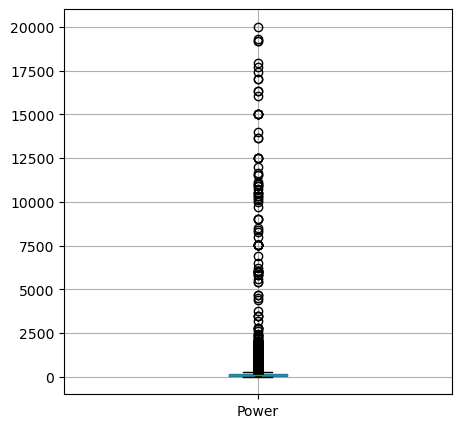

In [24]:
df.boxplot(column=['Power'], figsize=(5, 5));
plt.show();

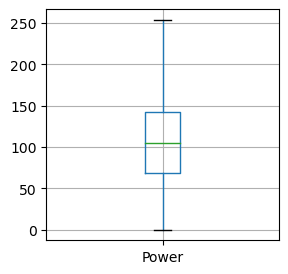

In [25]:
df.boxplot(column=['Power'], showfliers=False, figsize=(3, 3));#посмотрю без выбросов
plt.show();

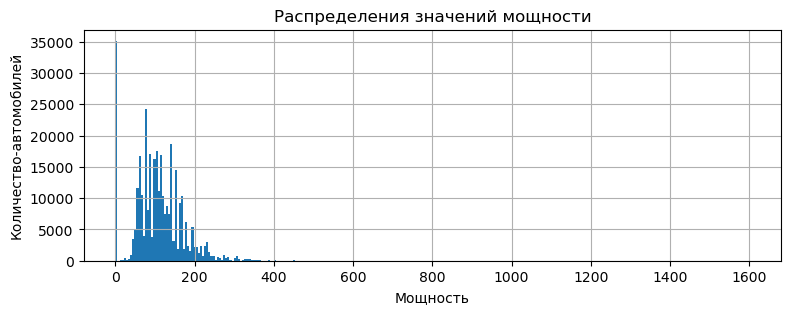

In [26]:
df.Power.hist(bins=300,range=(0,1600), figsize=(9,3));
plt.title('Распределения значений мощности')
plt.xlabel('Мощность')
plt.ylabel('Количество-автомобилей')
plt.show()

Большая часть автомобилей имеют мощность от 50 до 150. Удалю из датасета автомобили с мощностью менее 1 и более 500 л.с.

In [27]:
df['Power'].value_counts() 

Power
0       35118
75      22757
60      15140
150     14109
101     12716
        ...  
2331        1
2789        1
519         1
2461        1
3           1
Name: count, Length: 695, dtype: int64

Заполняю нули медианой по бренду

In [28]:
df.loc[df['Power'] == 0, 'Power'] = df.groupby('Brand')['Power'].transform(lambda x: x.median())#заполняю 0 медианой по бренду

In [29]:
df['Power'].value_counts()#проверка 

Power
90      28127
75      25495
150     16923
60      15140
101     13629
        ...  
612         1
1596        1
1506        1
5809        1
3           1
Name: count, Length: 694, dtype: int64

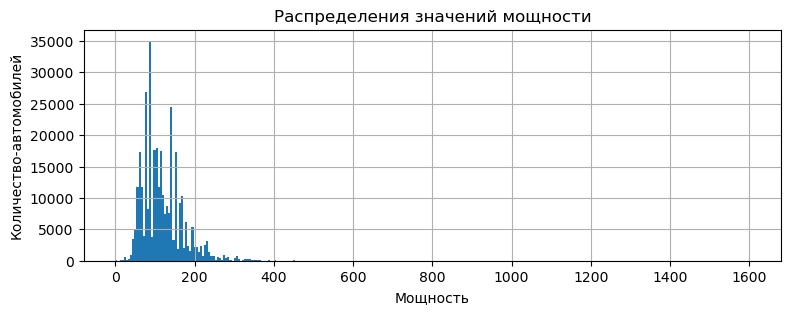

In [30]:
df.Power.hist(bins=300,range=(0,1600), figsize=(9,3));
plt.title('Распределения значений мощности')
plt.xlabel('Мощность')
plt.ylabel('Количество-автомобилей')
plt.show()

In [31]:
df = df.loc[(df['Power']> 1) & (df['Power'] < 500)]
df

Price  VehicleType  RegistrationYear Gearbox  Power        Model   
0         480          NaN              1993  manual     90         golf  \
1       18300        coupe              2011  manual    190          NaN   
2        9800          suv              2004    auto    163        grand   
3        1500        small              2001  manual     75         golf   
4        3600        small              2008  manual     69        fabia   
...       ...          ...               ...     ...    ...          ...   
354363   1150          bus              2000  manual     90       zafira   
354364      0          NaN              2005  manual    102         colt   
354366   1199  convertible              2000    auto    101       fortwo   
354367   9200          bus              1996  manual    102  transporter   
354368   3400        wagon              2002  manual    100         golf   

        Kilometer  FuelType       Brand Repaired  
0          150000    petrol  volkswagen      NaN  
1          125000  gasoline        audi      yes  
2          125000  gasoline        jeep      NaN  
3          150000    petrol  volkswagen       no  
4           90000  gasoline       skoda       no  
...           ...       ...         ...      ...  
354363     150000    petrol        opel       no  
354364     150000    petrol  mitsubishi      yes  
354366     125000    petrol       smart       no  
354367     150000  gasoline  volkswagen       no  
354368     150000  gasoline  volkswagen      NaN  

[336026 rows x 10 columns]

<b> Рассмотрю целевой признак -  цена (Price) <b>

In [32]:
df['Price'].value_counts()

Price
0        9471
500      5404
1500     5047
1200     4294
1000     4293
         ... 
6235        1
1379        1
5377        1
3021        1
10985       1
Name: count, Length: 3674, dtype: int64

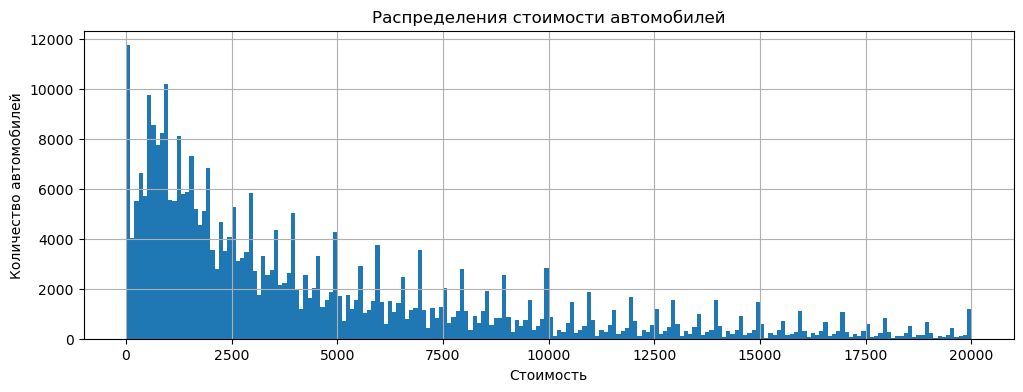

In [33]:
df['Price'].hist(bins=200, figsize=(12, 4));
plt.title('Распределения стоимости автомобилей')
plt.xlabel('Стоимость')
plt.ylabel('Количество автомобилей')
plt.show()

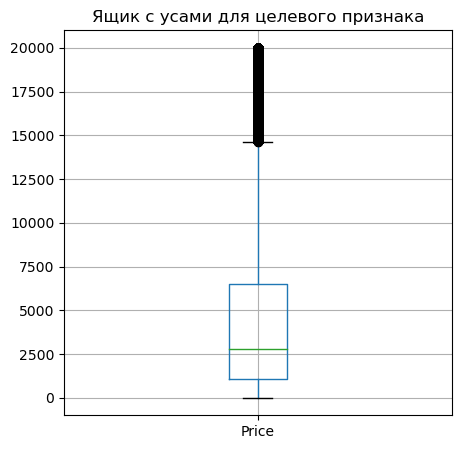

In [34]:
df.boxplot(column=['Price'], figsize=(5, 5));
plt.title('Ящик с усами для целевого признака')
plt.show()

In [35]:
df['Price'].quantile([.05, 0.95])#посмотрю значения квантилей (5 и 95)

0.05      200.0
0.95    14750.0
Name: Price, dtype: float64

In [36]:
df_p = df.loc[(df['Price'] < 300) | (df['Price'] > 14990)]
df_p.shape[0] / df.shape[0]#посмотрю какую долю от общих данных занимают строки, где цена меньше 300 и больше 14990

0.10892609500455322

In [37]:
df = df.loc[(df['Price'] > 300) | (df['Price'] < 14990)]#удалю цену меньше 300 и больше 14990

Приступлю к заполнению пропусков. 
Для начала посмотрю корреляцию признаков.

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


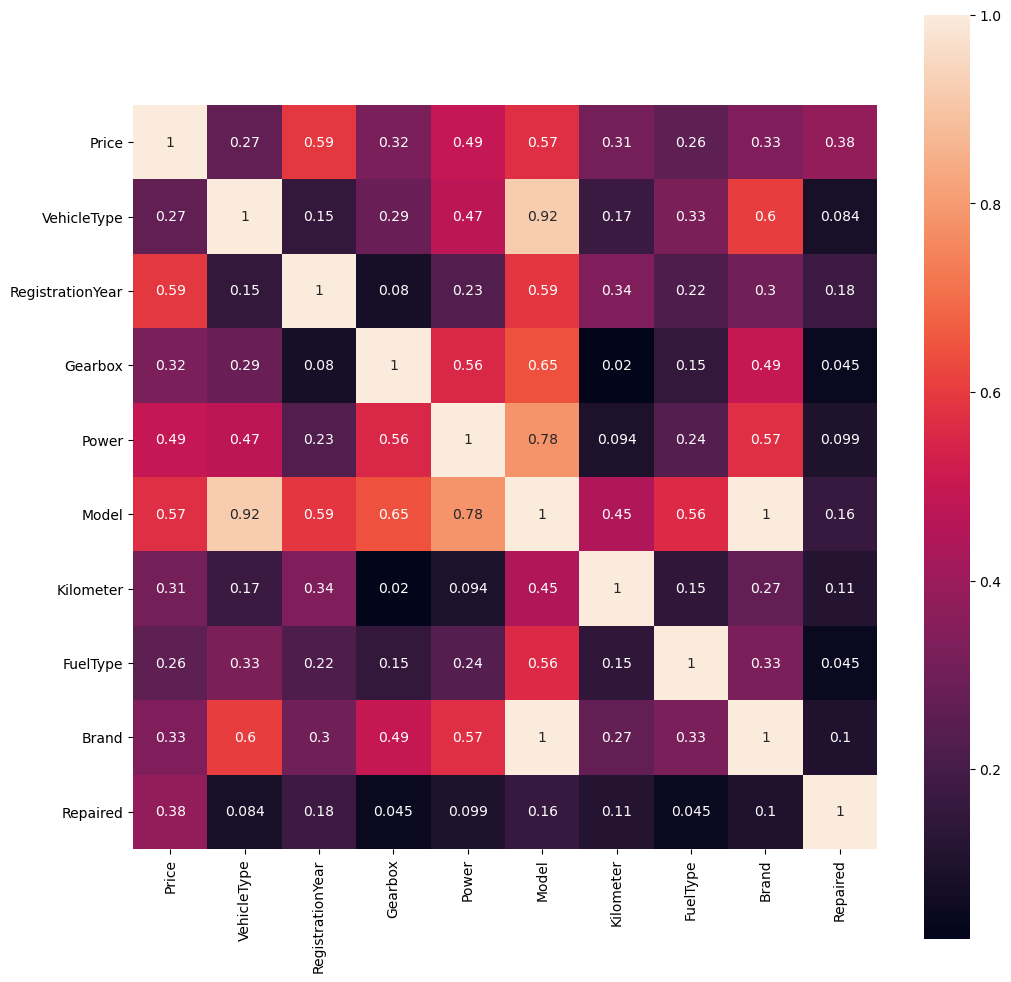

In [38]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.phik_matrix(), annot=True, square=True);
plt.show()

Самая большая корреляция всех признаков с признаком Модель.

Модель и бренд - 1 сильная корреляция
модель и тип автомобильного кузова - 0,92 сильная корреляция
модель и мощность - 0,8 сильная корреляция
модель и тип коробки передач - 0,65 умеренная корреляция
модель и тип топлива - 0,56 - умеренная корреляция
модель и ЦЕНА - 0,58 - умеренная корреляция
модел и киллометраж - 0,45 - умеренная корреляция

Так как перечисленные признаки зависят от моделей, то пропуски буду заполнять в соответствии со столбцом Модель самым популярным значением.

In [39]:
df['Model'].isna().sum()
df['Model'] = df.groupby('Brand')['Model'].transform(lambda x: x.fillna(x.value_counts().idxmax()))

df['Model'].isna().sum()

0

In [40]:
omissions = ['VehicleType', 'Gearbox', 'FuelType']

'Количество пропусков в столбце VehicleType до заполнения:'

21964

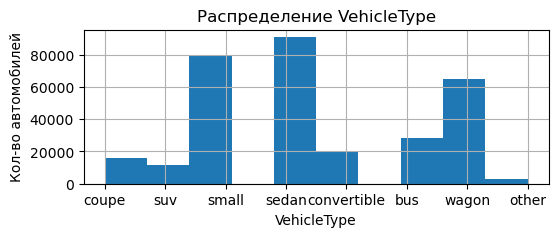

'Количество пропусков в столбце VehicleType после заполнения:'

0

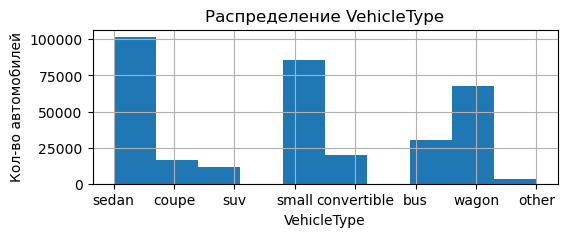

'Количество пропусков в столбце Gearbox до заполнения:'

16836

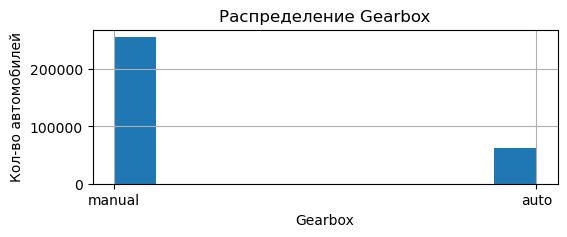

'Количество пропусков в столбце Gearbox после заполнения:'

0

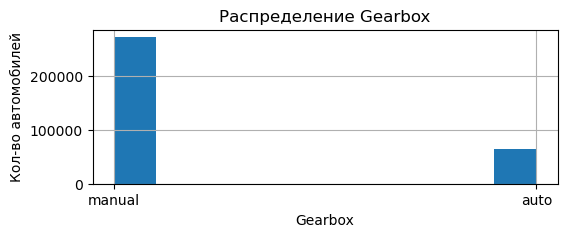

'Количество пропусков в столбце FuelType до заполнения:'

26139

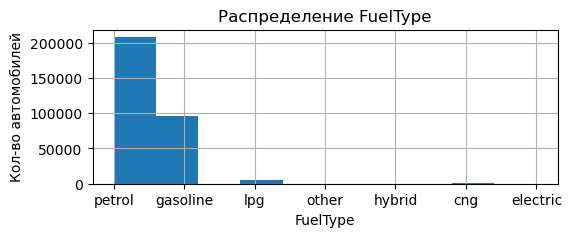

'Количество пропусков в столбце FuelType после заполнения:'

0

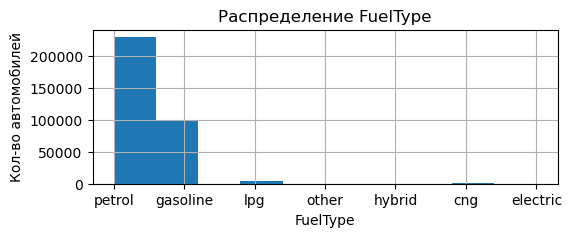

In [41]:
for i in omissions:
    display(f'Количество пропусков в столбце {i} до заполнения:', df[i].isna().sum())
    df[i].hist(figsize=(6, 2));
    plt.title(f'Распределение {i}')
    plt.xlabel(i)
    plt.ylabel('Кол-во автомобилей')
    plt.show();
    df[i] = df.groupby('Model')[i].transform(lambda x: x.fillna(x.value_counts().idxmax()))#заполняю пропуски модой по момдели
    display(f'Количество пропусков в столбце {i} после заполнения:',df[i].isna().sum())
    df[i].hist(figsize=(6, 2));
    plt.title(f'Распределение {i}')
    plt.xlabel(i)
    plt.ylabel('Кол-во автомобилей')
    plt.show();

Распределение после заполнения критично не изменилось.

In [42]:
df['Repaired'] = df['Repaired'] .fillna('unknown')#пропуски в столбце "Была ли в ремонте" заполню - "неизвестно"

In [43]:
df.isna().sum()#проверка

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336026 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             336026 non-null  int64 
 1   VehicleType       336026 non-null  object
 2   RegistrationYear  336026 non-null  int64 
 3   Gearbox           336026 non-null  object
 4   Power             336026 non-null  int64 
 5   Model             336026 non-null  object
 6   Kilometer         336026 non-null  int64 
 7   FuelType          336026 non-null  object
 8   Brand             336026 non-null  object
 9   Repaired          336026 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.2+ MB


In [45]:
df

Price  VehicleType  RegistrationYear Gearbox  Power        Model   
0         480        sedan              1993  manual     90         golf  \
1       18300        coupe              2011  manual    190           a4   
2        9800          suv              2004    auto    163        grand   
3        1500        small              2001  manual     75         golf   
4        3600        small              2008  manual     69        fabia   
...       ...          ...               ...     ...    ...          ...   
354363   1150          bus              2000  manual     90       zafira   
354364      0        sedan              2005  manual    102         colt   
354366   1199  convertible              2000    auto    101       fortwo   
354367   9200          bus              1996  manual    102  transporter   
354368   3400        wagon              2002  manual    100         golf   

        Kilometer  FuelType       Brand Repaired  
0          150000    petrol  volkswagen  unknown  
1          125000  gasoline        audi      yes  
2          125000  gasoline        jeep  unknown  
3          150000    petrol  volkswagen       no  
4           90000  gasoline       skoda       no  
...           ...       ...         ...      ...  
354363     150000    petrol        opel       no  
354364     150000    petrol  mitsubishi      yes  
354366     125000    petrol       smart       no  
354367     150000  gasoline  volkswagen       no  
354368     150000  gasoline  volkswagen  unknown  

[336026 rows x 10 columns]

### Вывод

В результате предобработки были заполнены пропуски, удалены дубликаты и отброшены выбросы, также я удалила признаки, которые никак не влияют на целевой признак. В результате предобработки данных было удалено 15% данных (осталось 300 908 строк), но так как у нас достаточно данных, это не критично.

## Подготовка выборки для обучения моделей

In [46]:
#Объявлю две переменные: features — признаки и target — целевой признак.
features = df.drop('Price',axis=1)
target = df['Price']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=R)

features_train_orig = features_train.copy()
target_train_orig = target_train.copy()
features_test_orig = features_test.copy()
target_tes_orig = target_test.copy()


In [47]:
display(features_train.shape)
display(target_train.shape)

display(features_test.shape)
display(target_test.shape)

(252019, 9)

(252019,)

(84007, 9)

(84007,)

In [48]:
#Bзбавляюсь от категориальных признаковСделаем OHE-кодирование
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

#Сохраним список категориальных признаков 
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [49]:
#Обучим энкодер по тренировочным данным 
encoder_ohe.fit(features_train[ohe_features])

#Добавим закодированные признаки
features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features]) 
#features_valid[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid[ohe_features]) 
features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features])

#Удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1) 
#features_valid = features_valid.drop(ohe_features, axis=1) 
features_test = features_test.drop(ohe_features, axis=1)

In [50]:
display(features_train.shape)
display(target_train.shape)

display(features_test.shape)
display(target_test.shape)

(252019, 302)

(252019,)

(84007, 302)

(84007,)

## Анализ моделей

<b>Линейная регрессия <b>

In [51]:
%%time

model_linear = LinearRegression()
model_linear.fit(features_train, target_train)

CPU times: total: 20.9 s
Wall time: 17 s


LinearRegression()

In [52]:
%%time

prediction = model_linear.predict(features_train)
prediction

CPU times: total: 1.2 s
Wall time: 3.16 s


array([14696.91001517,   634.8774166 , 18502.57168218, ...,
         819.51793913,  2604.79918874,  8703.28783255])

In [54]:
%%time

# используем кросс-валидацию для оценки качества модели
all_rmse = np.sqrt(np.abs(cross_val_score(estimator=model_linear, X=features_train, y=target_train, cv=5, scoring='neg_mean_squared_error')))
mean_rmse_lg = np.mean(all_rmse)

print('Средний RMSE по кросс-валидации:', mean_rmse_lg)

Средний RMSE по кросс-валидации: 2730.90015291247
CPU times: total: 1min 21s
Wall time: 1min 1s


Время обучения и предсказания хорошее, но вот метрика по условиям задачи не проходит. Думаю, что это из-за выбросов, я избавлялась от них по минимому, но линейная регрессия очень сильно на них реагирует, метрики снижаются.

<b> Модель CatBoostRegressor <b>

На кодированных данных

In [55]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[R], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train.values, target_train.values)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_ohe = (max(mts) * -1) ** .5
gscv_rsme_cbr_ohe

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: total: 47min 30s
Wall time: 23min 29s


1685.6249981326919

In [56]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=R, verbose=False) #подставила лучшие параметры
model_cbr.fit(features_train.values, target_train.values)

CPU times: total: 2min 42s
Wall time: 57.8 s


In [59]:
%%time

# используем кросс-валидацию для оценки качества модели
all_rmse_cbr = np.sqrt(np.abs(cross_val_score(estimator=model_cbr, X=features_train.values, y=target_train.values, cv=5, scoring='neg_mean_squared_error')))
mean_rmse_cbr = np.mean(all_rmse_cbr)

print('Средний RMSE по кросс-валидации:', mean_rmse_cbr)


Средний RMSE по кросс-валидации: 1685.6158125215734
CPU times: total: 14min 46s
Wall time: 7min 10s


<b> Модель LightGBMRegressor <b>

На кодированных данных

In [60]:
%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[R]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}

CPU times: total: 15min 1s
Wall time: 8min 2s


1681.6317536532097

In [61]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=R)
model_lgbmr.fit(features_train, target_train)

CPU times: total: 15.6 s
Wall time: 5.97 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [62]:
%%time

target_predict = model_lgbmr.predict(features_train)

CPU times: total: 9.86 s
Wall time: 4.6 s


In [64]:
%%time

# используем кросс-валидацию для оценки качества модели
all_rmse_lgbmr_ohe = np.sqrt(np.abs(cross_val_score(estimator=model_lgbmr, X=features_train, y=target_train, cv=5, scoring='neg_mean_squared_error')))
mean_rmse_lgbmr_ohe = np.mean(all_rmse_lgbmr_ohe)

print('Средний RMSE по кросс-валидации:', mean_rmse_lgbmr_ohe)

Средний RMSE по кросс-валидации: 1681.610015575619
CPU times: total: 1min 26s
Wall time: 38.2 s


<font color='steelblue'> Для LGBMRegressor я так понимаю тоже надо исправить.Добавила блок выше  </font> 

In [65]:
#для наглядности соберу данные в сводную таблицу
index = ['Линейная регрессия с OHE',
         'CatBoostRegressor с OHE',
         'LGBMRegressor с OHE',
        ]

data = {'RMSE':[mean_rmse_lg,
                mean_rmse_cbr,
                mean_rmse_lgbmr_ohe],
        
        'Время обучения модели':['0 min 21 s',
                                 '2 min 42 s',
                                 '0 min 16 s'],
        
        'Время предсказания модели':['0 min 1 s',
                                     '0 min 2 s',
                                     '0 min 10 s']
       }

kpi_data = pd.DataFrame(data=data, index=index)
kpi_data

RMSE Время обучения модели   
Линейная регрессия с OHE  2730.900153            0 min 22 s  \
CatBoostRegressor с OHE   1685.615813            2 min 41 s   
LGBMRegressor с OHE       1681.610016            0 min 16 s   

                         Время предсказания модели  
Линейная регрессия с OHE                 0 min 2 s  
CatBoostRegressor с OHE                  0 min 2 s  
LGBMRegressor с OHE                     0 min 10 s

### Вывод

Лучшие результаты показала модель LGBMRegressor, метрика качества RMSE не на много выигрывает CatBoostRegressor, но по временным затратам на обучение модели отрыв значительный.

## Проверка качество лучшей модели на тестовой выборке

In [66]:
%%time

target_predict = model_lgbmr.predict(features_test)
final_rsme_lgbmr = mean_squared_error(target_test, target_predict) ** .5
final_rsme_lgbmr

CPU times: total: 3.62 s
Wall time: 3.5 s


1642.1211802088635

### Вывод

RMSE на тестовой выборке = 1642. Метрика на тестовых данных немного лучше.

##  Вывод

По ходу выполнения проекта были выполнены следующие задачи:

- выполнена предобработка данных - заполнены пропуски, удалены дубликаты и отброшены выбросы, также я удалила признаки, которые никак не влияют на целевой признак;

- Подготовить выборки для обучения моделей;

- Сравнила 3 модели (линейная регрессия, CatBoostRegressor, LGBMRegressor)  с разными гиперпараметрами, выбрала лучшую исходя из времени обучения, времени предсказания и значения RMSE;

- Наилучшая модель LGBMRegressor, на финальном тестировании RMSE=1668. 